# African Mountain Research Foundation and Digital Earth Africa

The [African Mountain Research Foundation](https://africanmountainresearch.com/) provides access to weather data from in-situ weather stations placed at high-altitude sites across southern Africa.

Weather data at high-altitude sites is scarce and modelled data is often relied upon. However, weather and climate at high altitudes are often shaped by unique microclimates resulting from local terrain, vegetation, and atmospheric conditions, so modelled data may lack accuracy.

Monitoring and understanding high-altitude environments is important because these mountains are often water sources for surrounding, lower-lying communities. Furthermore, they often host unique ecosystems.

This notebook shows how in-situ weather data from the African Mountain Research Foundation can be fused with spatial data from Digital Earth Africa and Copernicus to explore differences in these datasets.

## Install and load packages

This notebook was developed in Google Colab, but should run in any Python 3 environment. The cell below installs package requirements.

In [1]:
!pip install datacube cdsapi odc-stac pystac-client odc.algo --quiet

Next, packages are imported.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import datetime
import cdsapi
import odc.algo
import datacube

import xarray as xr
from scipy import stats
from datacube.utils import masking
from pystac_client import Client
from scipy.stats import gaussian_kde
from odc.stac import configure_rio, stac_load
from sklearn.metrics import mean_absolute_error

## Read in-situ weather data

We have stored some of the African Mountain Research Foundation Data in .csv format. In this case, we are working with data from Mt Mulanje which is in Malawi. We took daily weather data from the [Mulanje data page](https://jollyweather.com/mulanje/index.html#canvas_container) and organised it as a .csv file in Excel before adding it to this enviromnent.

Further weather stations are available on the [AMRF website](https://africanmountainresearch.com/the-solutions/data/).

Running the `.head()` function on the Pandas dataframe allows us to see the structure of the dataframe.

In [3]:
mulanje = pd.read_csv('data/Mulanje.csv')

mulanje.head()

,Timestamp,StationID,WSpd_Min,WSpd_TMn,WSpd_Max,WSpd_TMx,WSpd_Avg,WSpd_Std,WDir_Avg,WDir_Std,...,HI_C_Max,HI_C_TMx,SVPWkPa_Avg,Vp_Avg,TwC_Avg,SunHrs_Tot,WC_C_Min,WC_C_TMn,ETos,Rso
0,19/07/2023 0:00,AMRF_Mulanje_South_5828,0.0,18/07/2023 10:30,9.2,18/07/2023 11:58,1.3,1.2,4.0,73.6,...,16.4,18/07/2023 13:07,1.4,0.9,8.4,0,0.0,18/07/2023 10:30,2.1,0.1
1,20/07/2023 0:00,AMRF_Mulanje_South_5828,0.0,19/07/2023 0:00,9.2,19/07/2023 11:04,1.8,1.6,326.7,60.8,...,18.4,19/07/2023 14:18,1.5,0.9,8.4,0,5.1,19/07/2023 1:53,3.2,3.0
2,21/07/2023 0:00,AMRF_Mulanje_South_5828,0.0,20/07/2023 0:00,7.7,20/07/2023 20:41,1.6,1.0,103.9,67.0,...,18.0,20/07/2023 9:12,1.5,1.0,9.7,0,10.3,20/07/2023 4:02,1.6,3.0
3,22/07/2023 0:00,AMRF_Mulanje_South_5828,0.0,21/07/2023 1:27,7.7,21/07/2023 9:46,2.3,1.5,110.2,39.6,...,14.1,21/07/2023 14:36,1.3,1.2,9.7,0,6.2,21/07/2023 6:36,1.8,3.0
4,23/07/2023 0:00,AMRF_Mulanje_South_5828,0.0,22/07/2023 0:01,6.2,22/07/2023 12:43,1.0,1.1,125.0,74.4,...,16.6,22/07/2023 8:00,1.3,1.0,8.8,0,-0.2,22/07/2023 11:15,2.6,3.0


We can also list the column names so we can see the range of weather variables/measurements in the dataframe.

In [4]:
list(mulanje.columns.values)

['Timestamp',
 'StationID',
 'WSpd_Min',
 'WSpd_TMn',
 'WSpd_Max',
 'WSpd_TMx',
 'WSpd_Avg',
 'WSpd_Std',
 'WDir_Avg',
 'WDir_Std',
 'AirTemp_Min',
 'AirTemp_TMn',
 'AirTemp_Max',
 'AirTemp_TMx',
 'AirTemp_Avg',
 'RH_Min',
 'RH_TMn',
 'RH_Max',
 'RH_TMx',
 'DewPointTemp_Min',
 'DewPointTemp_TMn',
 'DewPointTemp_Max',
 'DewPointTemp_TMx',
 'DewPointTemp_Avg',
 'SlrW_Max',
 'SlrW_TMx',
 'SlrW_Avg',
 'SlrMJ_Tot',
 'Rain_Tot',
 'BPress_Min',
 'BPress_TMn',
 'BPress_Max',
 'BPress_TMx',
 'BPress_Avg',
 'LoggerSerialNumber',
 'ProgramName',
 'ProgramSignature',
 'LoggerBattery_Min',
 'LoggerBattery_TMn',
 'LoggerBattery_Max',
 'LoggerBattery_TMx',
 'LoggerBattery_Avg',
 'LoggerTemp_Min',
 'LoggerTemp_TMn',
 'LoggerTemp_Max',
 'LoggerTemp_TMx',
 'LoggerTemp_Avg',
 'LoggerLithiumBatt_Avg',
 'PingTime_Avg',
 'ScanCount',
 'HI_C_Max',
 'HI_C_TMx',
 'SVPWkPa_Avg',
 'Vp_Avg',
 'TwC_Avg',
 'SunHrs_Tot',
 'WC_C_Min',
 'WC_C_TMn',
 'ETos',
 'Rso']

### Organise in-situ data

We need to make a few adjustments to the data to get started on comparisons and exploration. First, we set the index as the Timestamp and make sure the data is read in a Datetime format.

In [5]:
mulanje.index = pd.DatetimeIndex(mulanje.Timestamp, dayfirst=True)

Next, we select data for the calendar year 2024.

In [6]:
mulanje = mulanje.loc['20240101':'20241231']

We can visualise different variables in the dataframe. Below, the daily average air temperature is plotted for each day in 2024.

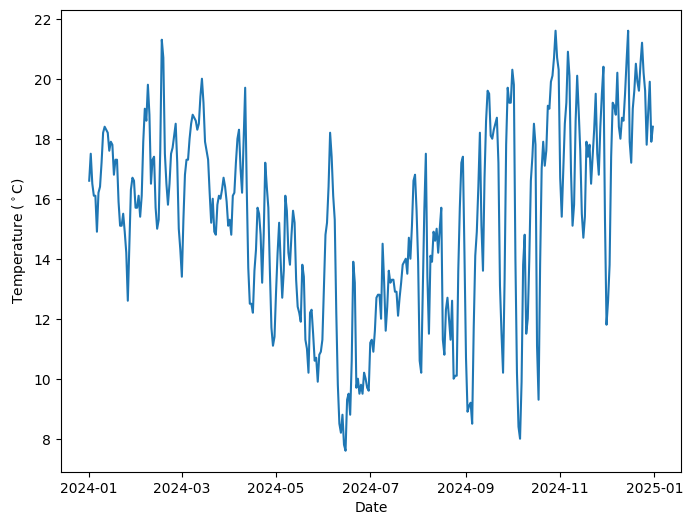

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_xlabel('Date')
ax.plot(mulanje.index, mulanje.AirTemp_Avg);

## Get ERA5 reanalysis data from Copernicus

We want to compare the in-situ temperature with data from the modelled ERA5 products. ERA5 is the latests [climate reanalysis](https://climate.copernicus.eu/climate-reanalysis) produced by the European Centre for Medium-Range Weather Forecasts (ECMWF). The data is available from the [Climate Data Store](https://cds.climate.copernicus.eu/) free, though you will need to [create an account](https://accounts.ecmwf.int/auth/realms/ecmwf/login-actions/registration?client_id=cds&tab_id=0P92pOkd_7k) if you don't already have one. Some [guidance is available](https://cds.climate.copernicus.eu/how-to-api) on how to use the API, though we don't need to install any software locally, assuming the notebook is running in a cloud environment like Colab.

Once you have an account, you can store the KEY somewhere safe. In this case, we have used the [Secrets feature](https://drlee.io/how-to-use-secrets-in-google-colab-for-api-key-protection-a-guide-for-openai-huggingface-and-c1ec9e1277e0) in Colab. It's important not to hard code the key anywhere public.

In [8]:
from google.colab import userdata

URL = 'https://cds.climate.copernicus.eu/api'
KEY = userdata.get('KEY')

DATADIR = 'data/'

Now the API is configured, we request daily mean temperature data so that it aligns in time with the in-situ data.

The area chosen is a small area (0.01 degrees ^2, about 1km^2) surrounding the weather station. The ERA5 product has a spatial resolution of about 9km, so we don't gain any precision by choosing a smaller area.

In [9]:
dataset = "derived-era5-land-daily-statistics"
request = {
    "daily_statistic": "daily_mean",
    "time_zone": "utc+02:00",         #Malawi GMT+2
    "variable": ["2m_temperature"],
    "year": ["2024"],
    "month": ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"],
    "day": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12",
        "13", "14", "15",
        "16", "17", "18",
        "19", "20", "21",
        "22", "23", "24",
        "25", "26", "27",
        "28", "29", "30",
        "31"
    ],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [-15.96, 35.53, -15.97, 35.54]
}

The next step is downloading the temperature data in NetCDF format into our data directory. This cell takes around a minute to run.

In [10]:
%%time

c = cdsapi.Client(url=URL, key=KEY)
c.retrieve(dataset, request, f'{DATADIR}Mulanje.nc')

2025-05-14 06:58:09,738 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-14 06:58:09,746 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-05-14 06:58:10,138 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-05-14 06:58:10,144 INFO Request ID is 20a7e061-eb88-4adb-b24c-6444071e2c01
INFO:ecmwf.datastores.legacy_clien

ecef778459db98bc3626caa17d29085f.nc:   0%|          | 0.00/25.3k [00:00<?, ?B/s]

CPU times: user 259 ms, sys: 30.1 ms, total: 289 ms
Wall time: 24 s


'data/Mulanje.nc'

Next, we inspect the temperature data we got from ERA5. Note that the temperature variable is called `t2m` (air temperature at 2 metres).

In [11]:
filename = f'{DATADIR}Mulanje.nc'
# Create Xarray Dataset
ds = xr.open_dataset(filename)

ds.squeeze()

<xarray.Dataset> Size: 4kB
Dimensions:     (valid_time: 366)
Coordinates:
    number      int64 8B ...
    latitude    float64 8B -15.97
    longitude   float64 8B 35.53
  * valid_time  (valid_time) datetime64[ns] 3kB 2024-01-01 ... 2024-12-31
Data variables:
    t2m         (valid_time) float32 1kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-12T23:09 GRIB to CDM+CF via cfgrib-0.9.1...

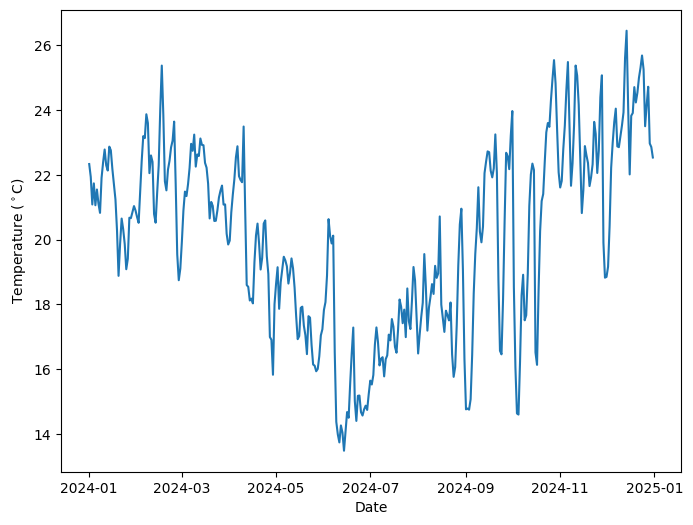

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_xlabel('Date')
ax.plot(ds.squeeze().valid_time, ds.squeeze().t2m-273.15);             # subtract 273.15 to convert K to C

### Plot a comparison between ERA5 and in-situ data

We can now compare the weather station data with ERA5 over time. The plot shows the two time-series following a similar pattern, though ERA5 looks consistently higher than the in-situ data.

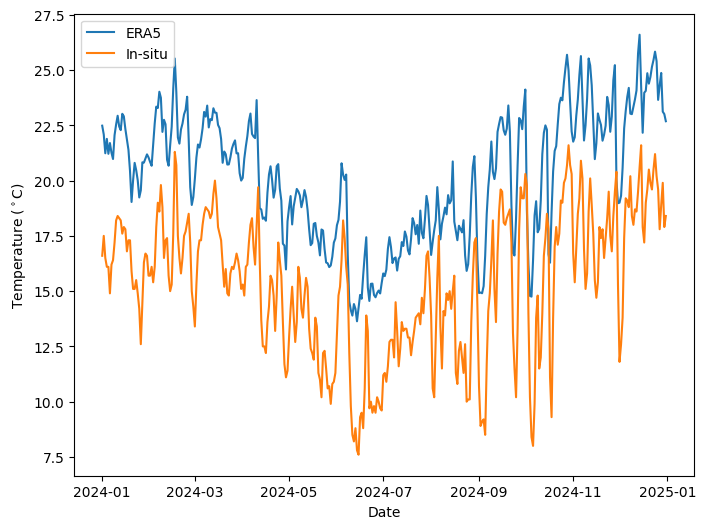

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(ds.squeeze().valid_time, ds.squeeze().t2m-273, label="ERA5")
ax.plot(mulanje.index, mulanje.AirTemp_Avg, label="In-situ")
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_xlabel('Date')
plt.legend();

### Perform a statistical comparison

The following cells compare the two temperature time-series on a statistical basis. This means we can draw conclusions about the similarity or difference between to two datasets in a more robust way than from a simple visual check.

First we construct a linear regression between the two datasets. Then, we calculate the mean absolute error, which can be interpreted as the average difference.

In [14]:
x=ds.squeeze().t2m.values-273
y=mulanje.AirTemp_Avg.values

slope, intercept, r, p, sd, = stats.linregress(x, y)

mae = mean_absolute_error(x, y)

The information presented below allows us to draw several conclusions:

* The ERA5 temperatures are higher than the in-situ values, this is evident because the regression line sits to the right of/below the 1:1 line.
* The ERA5 temperatures are _consistently_ higher across the entire range of temperatures; the difference is the same and does not vary as temperatures change. This is evident because the coefficient in the linear equation is close to 1, and therefore close to parallel to the 1:1 line.
* The ERA5 temperature is consistently 4.87 $^\circ$C greater than the temperature measured in-situ, based on the Mean Absolute Error.

linear eq: y = 0.985*x + -4.544
MAE:  4.8697 (°C)




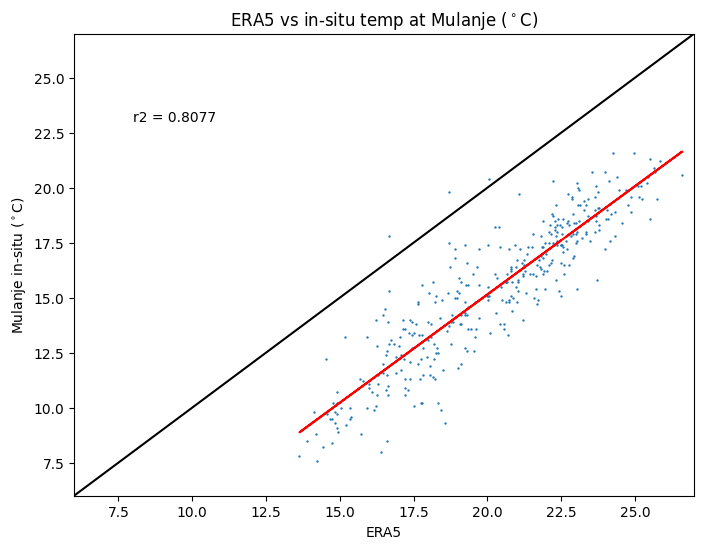

In [15]:
print(f'linear eq: y = {slope:.3f}*x + {intercept:.3f}')
print("MAE: ", round(mae, 4), u'(\u00B0C)')
print('\n')
fig, ax = plt.subplots(1,1, sharey=True, figsize=(8,6))
plt.scatter(x, y, s=0.5)
plt.plot(x, intercept + slope * x, '-', c='red')
plt.text(8,23,"r2 = "+str(round(r**2,4)))
ax.set_xlim(6, 27)                              # set the axes so they are equal length
ax.set_ylim(6, 27)
ax.plot([6, 27], [6, 27], 'k-')
ax.set_xlabel('ERA5')
ax.set_ylabel('Mulanje in-situ ($^\circ$C)')
ax.set_title('ERA5 vs in-situ temp at Mulanje ($^\circ$C)');

## Surface Temperature Data

Earth Observation satellites can measure surface temperature, such as the Landsat satellites. Digital Earth Africa [makes this data available for the African continent](https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Datasets/Landsat_Surface_Temperature.html).

Surface temperature differs from air temperature. Solar energy generally heats surfaces (especially non-liquids) more efficiently than it heats air. Therefore, surface temperature is often [higher than air temperature during the day](https://mynasadata.larc.nasa.gov/mini-lessonactivity/surface-and-air-temperatures-throughout-day) as the surface heats more rapidly. The difference then decreases at night as surfaces release heat into the air.

The next section of this notebook investigates surface temperature in comparison with air temperature.

First, we load surface temperature from Digital Earth Africa's Landsat 8 & 9 Surface Temperature products.

In [16]:
configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
    AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com",
)

# Open the stac catalogue
catalog = Client.open("https://explorer.digitalearth.africa/stac")

The next cell sets the area of interest, products we want to query, and conducts the search of STAC items.

In [17]:
# Set the bounding box
bbox = [35.526, -15.977,  35.527, -15.978] # [xmin, ymin, xmax, ymax] in latitude and longitude

# Set a start and end date
start_date = "2024-01-01"
end_date = "2024-12-31"

# Set the STAC collections
collections = ["ls8_st", "ls9_st"]

# Build a query with the set parameters
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 45 datasets


We set the configuration for the data and load it using the `odc-stac` package.

In [18]:
# Set config for DE Africa chirps rainfall
config = {
    "ls8_st": {                                 # ok to just have ls8
        "assets": {
            "ST_B10": {
                "data_type": "uint16",
                "aliases": ['st'],
                "nodata": 0,
                "unit": "Kelvin"
            },
            "QA_PIXEL": {
                "data_type": "uint16",
                "nodata": 1,
                "unit": "bit_index",
            },
        },
    }
}



# Load rainfall data
ds = stac_load(
             items,
             output_crs='EPSG:6933',
             bands=["ST_B10", "QA_PIXEL"],
             resolution=30,                 # 30m x 30m
             chunks={},
             groupby="solar_day",
             stac_cfg=config,
             bbox=bbox)

Surface temperature measurements from satellites can be affected by atmospheric interference e.g. from clouds. Below, we set the configuratino for the pixel quality band so we can mask poor quality pixels.

In [19]:
ds.QA_PIXEL.attrs = {'units': 'bit_index',
                    'nodata': 1,
                    'flags_definition': {'snow': {'bits': 5,
                      'values': {'0': 'not_high_confidence', '1': 'high_confidence'}},
                      'clear': {'bits': 6, 'values': {'0': False, '1': True}},
                      'cloud': {'bits': 3,
                      'values': {'0': 'not_high_confidence', '1': 'high_confidence'}},
                      'water': {'bits': 7, 'values': {'0': 'land_or_cloud', '1': 'water'}},
                      'cirrus': {'bits': 2,
                      'values': {'0': 'not_high_confidence', '1': 'high_confidence'}},
                      'nodata': {'bits': 0, 'values': {'0': False, '1': True}},
                      'cloud_shadow': {'bits': 4,
                      'values': {'0': 'not_high_confidence', '1': 'high_confidence'}},
                      'dilated_cloud': {'bits': 1, 'values': {'0': 'not_dilated', '1': 'dilated'}},
                      'cloud_confidence': {'bits': [8, 9],
                      'values': {'0': 'none', '1': 'low', '2': 'medium', '3': 'high'}},
                      'cirrus_confidence': {'bits': [14, 15],
                      'values': {'0': 'none', '1': 'low', '2': 'reserved', '3': 'high'}},
                      'snow_ice_confidence': {'bits': [12, 13],
                      'values': {'0': 'none', '1': 'low', '2': 'reserved', '3': 'high'}},
                      'cloud_shadow_confidence': {'bits': [10, 11],
                      'values': {'0': 'none', '1': 'low', '2': 'reserved', '3': 'high'}}},
                    'crs': 'epsg:32633',
                    'grid_mapping': 'spatial_ref'}

The next cell performs the masking based on some functions from the `odc.algo` package, using some code included in Digital Earth Africa's [`load_ard()`](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/main/Tools/deafrica_tools/datahandling.py) function

In [20]:
categories_to_mask_ls=dict(
        cloud="high_confidence", cloud_shadow="high_confidence"
    )

mask, _ = masking.create_mask_value(
  ds['QA_PIXEL'].attrs["flags_definition"], **categories_to_mask_ls
  )

pq_mask = (ds['QA_PIXEL'] & mask) != 0

invalid = (
        ((ds['ST_B10'] < (-1.0 * -0.2 / 0.0000275)) & (ds['ST_B10'] > 0)))

#merge masks
pq_mask = np.logical_or(pq_mask, pq_mask)

ds['ST_B10'] = odc.algo.erase_bad(ds['ST_B10'], where=pq_mask)

We then need to deal with NaN data (encoded as 0) and apply a scaling factor to the data. In this case, the scaling equation is `0.00341802x + 149.0` as defined in the [Landsat Collection 2 Level 2 Science Products information](https://www.usgs.gov/landsat-missions/landsat-collection-2-level-2-science-products).

After re-scaling, temperature is expressed in Kelvin, so we subtract 273.15 to return the data in degrees celsius.

In [21]:
ds = ds.where(ds['ST_B10'] !=0)
ds = ds * 0.00341802 + 149.0                      # re-scaling

ds = ds.dropna(dim='time', how='all') - 273.15    # K to C

/usr/local/lib/python3.11/dist-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


We can then inspect the surface temperature data in space. We can only a few pixels because of the very small area we're dealing with.

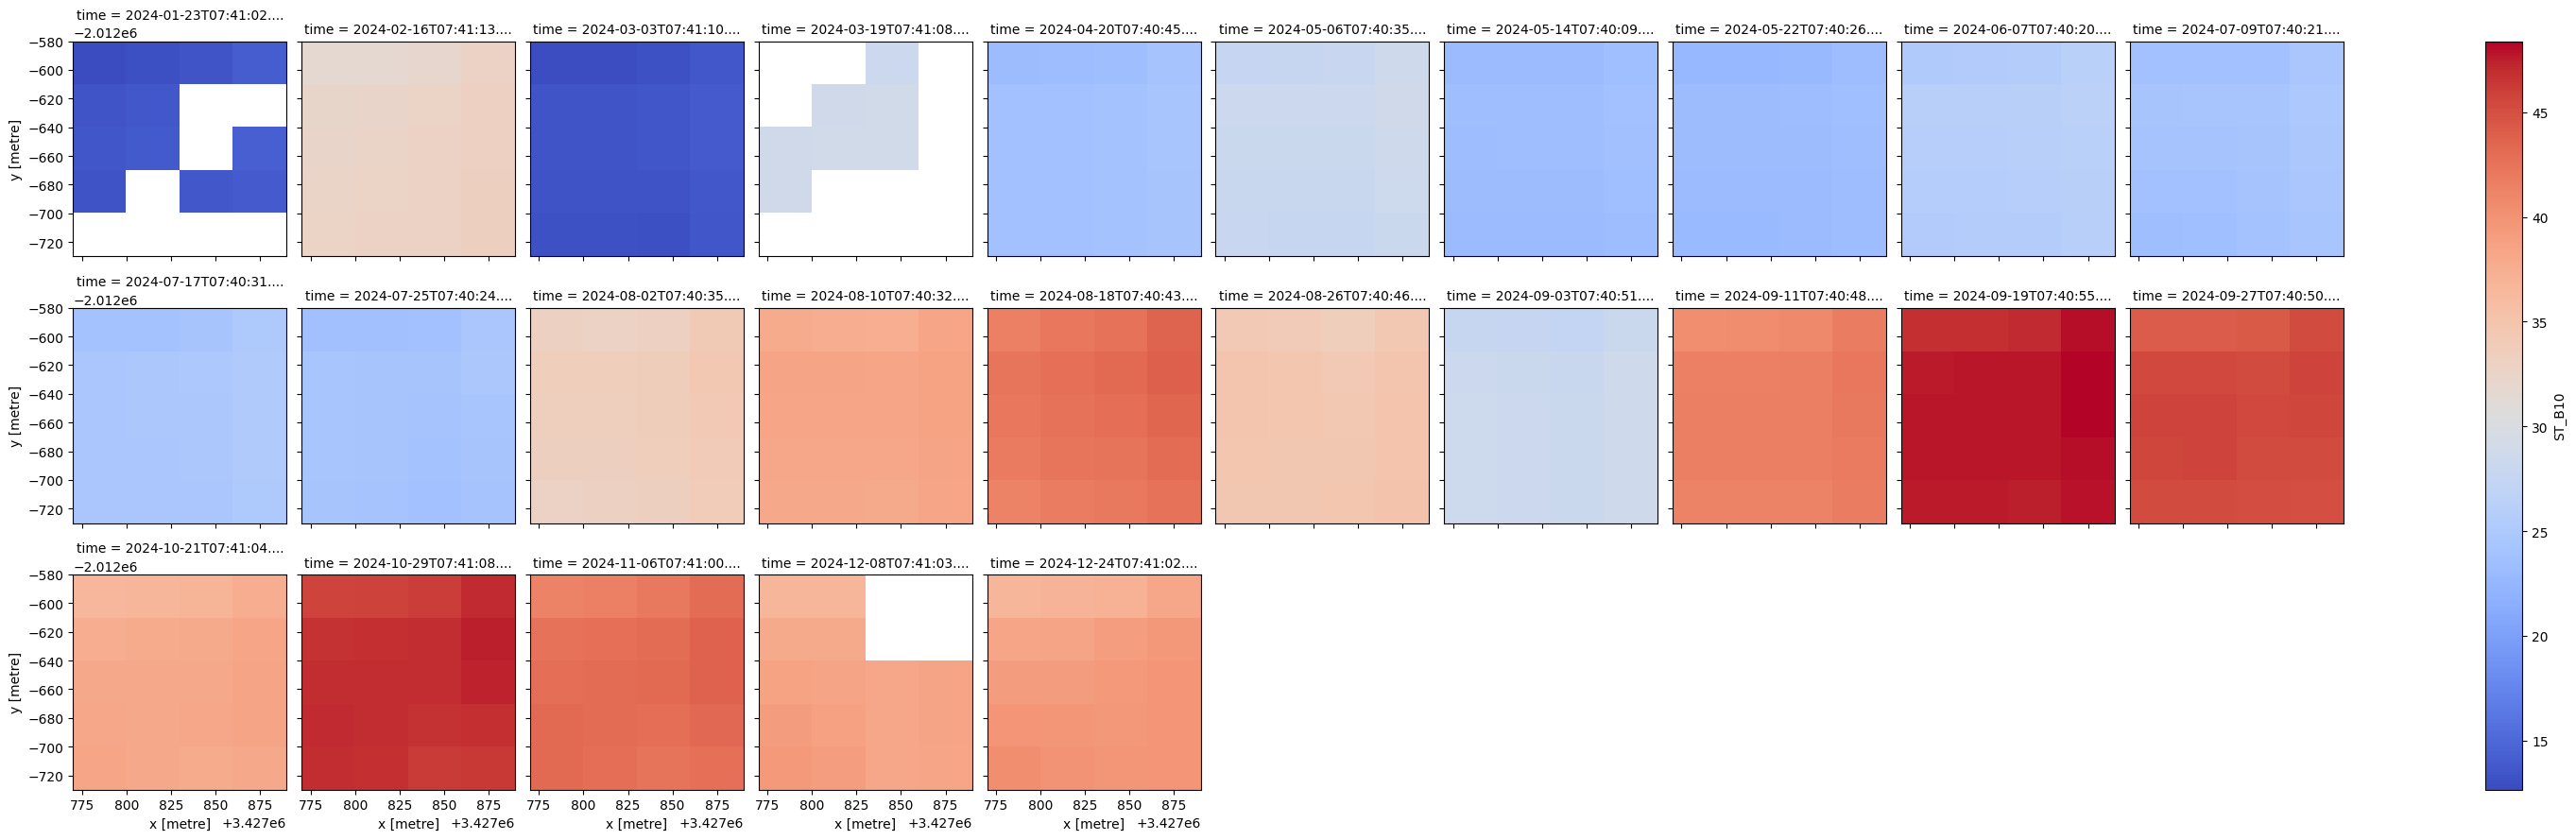

In [22]:
ds['ST_B10'].plot.imshow(col='time', col_wrap=10, cmap='coolwarm');

The next plot compares air temperature measured in-situ with surface temperature collected from satellites. We can draw the following conclusions:
* The air temperature data collected in-situ is measured each day and therefore provides a richer time-series.
* Surface temperature is consistently higher than air temperature. This is expected because Landsat satellites follow [sun-synchronous orbit](https://en.wikipedia.org/wiki/Sun-synchronous_orbit).
* The surface reaches quite high temperatures of >40$^\circ$C at some times of the year. It would be interesting to check out the type of surface and have a look at surface temperature over a broader area to detect any patterns.

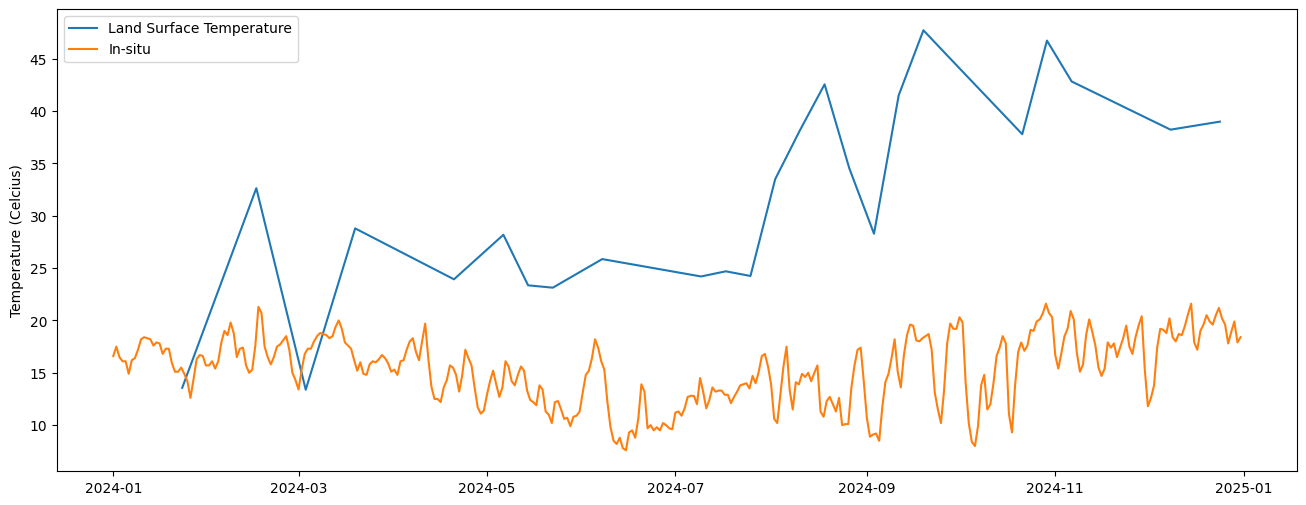

In [23]:
ds_mean = ds.groupby('time').mean(dim=xr.ALL_DIMS)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(ds_mean.time, ds_mean['ST_B10'], label='Land Surface Temperature');
ax.plot(mulanje.index, mulanje.AirTemp_Avg, label="In-situ")
plt.ylabel('Temperature (Celcius)')
plt.legend()

## Rainfall Data

The next section of this notebook compares rainfall data from the in-situ station with data from the Climate Hazards Group InfraRed Precipitation with Station (CHIRPS) dataset, available through Digital Earth Africa.

First, the area of interest is reset, noting that the spatial resolution of CHIRPS is 5km.

In [24]:
bbox = [35.53, -15.96,  35.54, -15.97] # [xmin, ymin, xmax, ymax] in latitude and longitude

# Set the STAC collections
collections = ["rainfall_chirps_monthly"]

# Build a query with the set parameters
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 10 datasets


Next, configuration is set and data is loaded into `xarray` format for further analysis.

In [25]:
# Set config for DE Africa chirps rainfall
config = {
    "rainfall_chirps_monthly": {
        "assets": {
            "rainfall": {
                "data_type": "float32",
                "nodata": -9999,
                "unit": "mm"
            },
        },
    }
}



# Load rainfall data
ds = stac_load(
             items,
             output_crs='EPSG:4326',
             bands="rainfall",
             resolution=0.05,
             chunks={},
             groupby="solar_day",
             stac_cfg=config,
             bbox=bbox)

We remove the no data values.

In [26]:
ds = ds.where(ds !=-9999)

The spatial plot shows we have one pixel with values for monthly total rainfall, for only 10 months of the year.

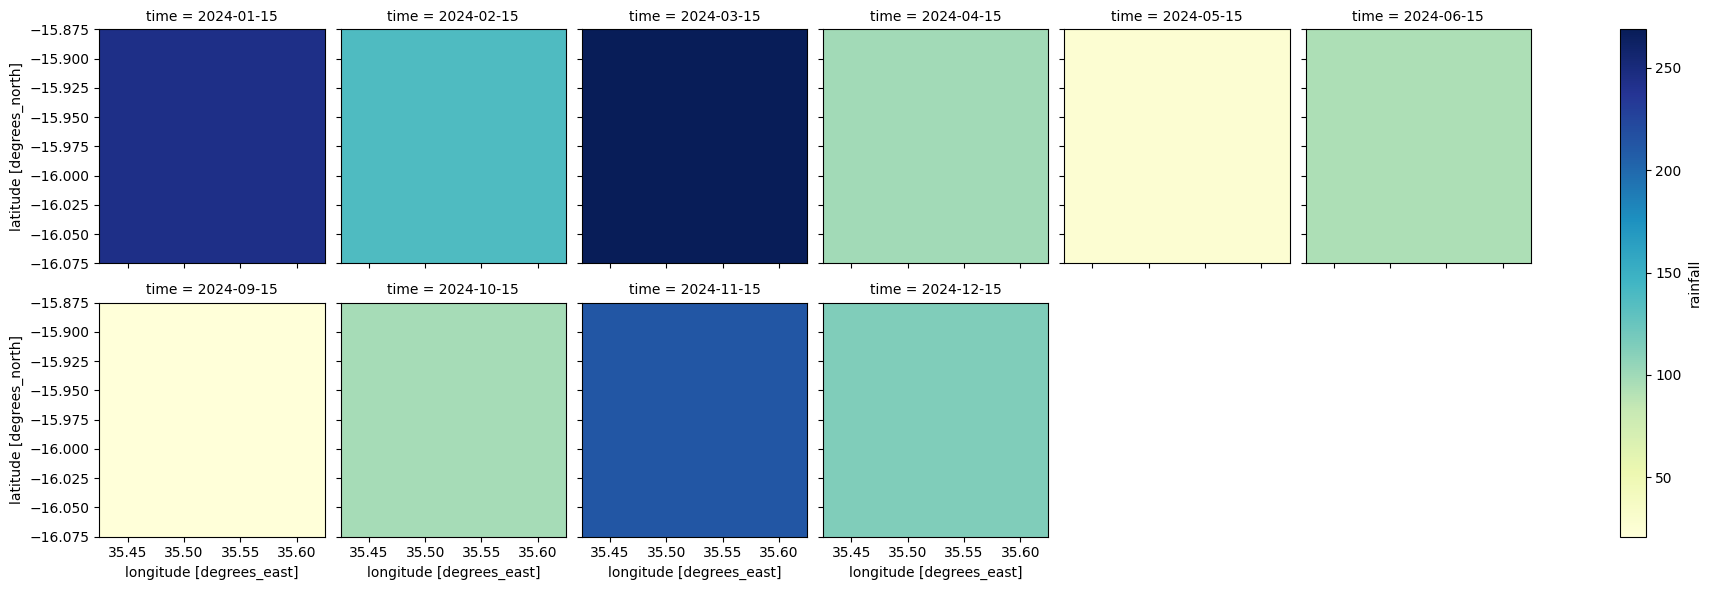

In [27]:
#facet plot rainfall
ds['rainfall'].compute().plot.imshow(col='time', col_wrap=6, cmap='YlGnBu', label=False);

To enable comparison, we prepare the in-situ Mt Mulanje data summed on a monthly basis.

In [28]:
mulanje_rain = mulanje.Rain_Tot.groupby(pd.Grouper(freq='ME')).sum()

mulanje_rain

,Rain_Tot
Timestamp,
2024-01-31,798.2
2024-02-29,600.6
2024-03-31,430.4
2024-04-30,451.8
2024-05-31,98.2
2024-06-30,287.4
2024-07-31,0.0
2024-08-31,10.6
2024-09-30,211.0


We then prepare the CHIRPS data in a similar manner. In this case, we have to drop the spatial dimensions and convert the data from an `xarray` object to a Pandas dataframe. We also have to add 0 values for the missing months to complete the time-series.

In [29]:
chirps_rainfall = ds.where(ds!=-9999.).squeeze(drop=True).drop_vars('spatial_ref').to_dataframe()

new_months = pd.DataFrame({"Timestamp": ["2024-07-15 00:00:00", "2024-08-15 00:00:00"], "rainfall": [0, 0]})

new_months.set_index('Timestamp', inplace=True)

chirps_rainfall = pd.concat([chirps_rainfall, new_months])
chirps_rainfall

,rainfall
2024-01-15 00:00:00,243.614777
2024-02-15 00:00:00,137.675949
2024-03-15 00:00:00,268.698303
2024-04-15 00:00:00,98.856384
2024-05-15 00:00:00,26.007278
2024-06-15 00:00:00,94.382195
2024-09-15 00:00:00,21.121849
2024-10-15 00:00:00,96.607445
2024-11-15 00:00:00,212.534119
2024-12-15 00:00:00,113.629494


Plotting a bar chart shows the two datasets follow a similar seasonal pattern, though the in-situ rainfall measurements are higher than the CHIRPS values.

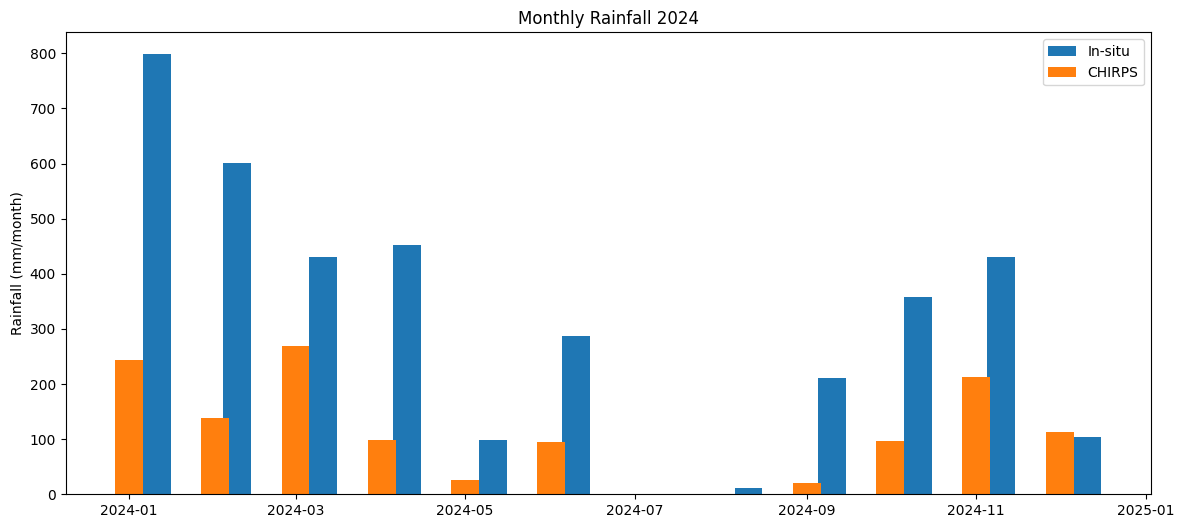

In [30]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.bar(mulanje_rain.index - pd.Timedelta(days=20), mulanje_rain, width=10, label='In-situ')
ax.bar(pd.to_datetime(chirps_rainfall.index) - pd.Timedelta(days=14), chirps_rainfall.rainfall, width=10, label='CHIRPS')
ax.legend()

plt.title('Monthly Rainfall 2024')
plt.ylabel('Rainfall (mm/month)');

Next, we conduct the statistical comparison between the in-situ and CHIRPS data to better understand the difference. In this case, the comparison is quite limited because we only have 10 meaningful values.

In [31]:
x=chirps_rainfall.rainfall.values
y=mulanje_rain.values

slope, intercept, r, p, sd, = stats.linregress(x, y)

mae = mean_absolute_error(x, y)

We can draw the following conclusions from the information below:
* The in-situ monthly rainfall totals are greater than the CHIRPS values, because the regression line (red) is to the left of/above the 1:1 line.
* CHIRPS is more likely to record more rainfall per month at lower values. This is evident because the coefficient in the linear regression is >1, so the difference between the datasets is greater with increasing rainfall. Also, there are some observations close to 0 in-situ where CHIRPS was closer to 100mm.

These conclusions are limited by the small sample size.


linear eq: y = 1.487*x + 152.352
MAE:  223.7833




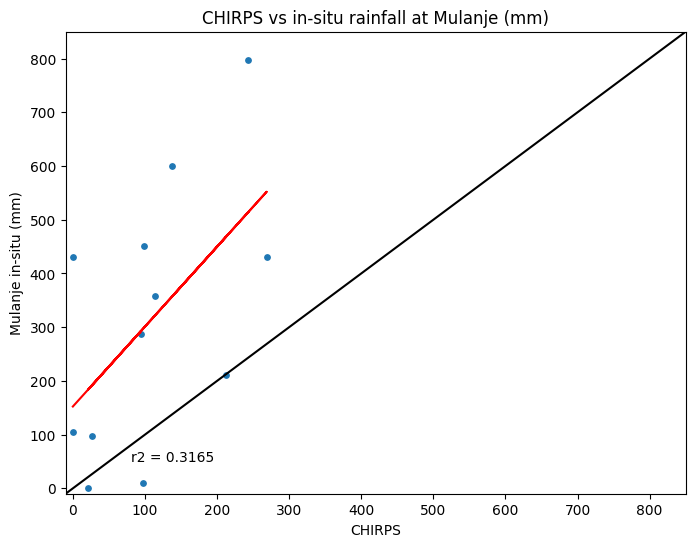

In [32]:
print(f'linear eq: y = {slope:.3f}*x + {intercept:.3f}')
print("MAE: ", round(mae, 4))
print('\n')
fig, ax = plt.subplots(1,1, sharey=True, figsize=(8,6))
plt.scatter(x, y, s=15)
plt.plot(x, intercept + slope * x, '-', c='red')
plt.text(80,50,"r2 = "+str(round(r**2,4)))
ax.set_xlim(-10, 850)                              # set the axes so they are equal length
ax.set_ylim(-10, 850)
ax.plot([-10, 850], [-10, 850], 'k-')
ax.set_xlabel('CHIRPS')
ax.set_ylabel('Mulanje in-situ (mm)')
ax.set_title('CHIRPS vs in-situ rainfall at Mulanje (mm)');

#Conclusions

This notebook has explored fusing in-situ data from the African Mountain Research Foundation with spatial data from Digital Earth Africa and Copernicus. The advantage of spatial data is that it's available everywhere (in this case, on the African continent), and can be a cost-effective means of monitoring the Earth. In-situ data is limited in its application to only one location, though is generally more accurate.

We need both kinds of data to understand different environments and develop more innovative monitoring methods for the future.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [33]:
print(datacube.__version__)

1.9.3


**Last Tested:**

In [34]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2025-05-14'

In [35]:
from ipywidgets import Widget

Widget.close_all()